In [1]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook

In [2]:
device = "cpu"

In [3]:
data = pd.read_csv("data/SBUX.csv", index_col=["Date"], date_format="%Y-%m-%d") #날짜 안쓸거라서 그냥 index로 보내버림
data["Volume"]=data["Volume"].astype(float) #int라서 다른애들처럼 float로 맞춰줌
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2019-12-11 to 2020-12-10
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       253 non-null    float64
 1   High       253 non-null    float64
 2   Low        253 non-null    float64
 3   Close      253 non-null    float64
 4   Adj Close  253 non-null    float64
 5   Volume     253 non-null    float64
dtypes: float64(6)
memory usage: 13.8 KB


In [4]:
X = data.iloc[:, :-1]
y = data.iloc[:, 5:6] #5:6이니까 인덱스가 5인 열만 인덱싱 해온다. 
print(X, y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]                 Volume
Date                  
2019-12

In [5]:
ms = MinMaxScaler()
ss = StandardScaler()

X_ss=ss.fit_transform(X)
y_ms=ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

In [6]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(200, 5) (53, 5) (200, 1) (53, 1)


### pytorch 로 변경

* 데이터를 텐서로 변경
* 모델 설계
* 모델 생성 후 학습, 예측, 검증

In [7]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))
y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [8]:
#주의

X_train_tensors_f=torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f=torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))
print(X_train_tensors.shape, X_train_tensors.shape)

torch.Size([200, 5]) torch.Size([200, 5])


### model 작성

* 생성자 작성 시 : 그 모델 작성 위해서 내가 써야 하는 parameters (torch models document 참조)

In [9]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        #num_classes - 아웃풋 갯수, input_size - column 몇개? hidden_size= 단기기억메모리 즉 은닉층 몇개? num_layers = 한층짜리레이어 몇개?
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length

        self.lstm = nn.LSTM(
                input_size = input_size,
                hidden_size = hidden_size,
                num_layers = num_layers,
                batch_first=True) #batch_first-나온 텐서의 시퀸스 바꾸는 옵션
        
                            #맨끝부분이 hidden_size라는거 알자나
        self.fc_1=nn.Linear(hidden_size, 128)
        self.fc=nn.Linear(128, num_classes)
        self.relu=nn.ReLU()

    def forward(self, x): #hidden_state.shape 했을때 torch.Size([1, 3, 20] 에서 근거
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #h_0, c_0:히든레이어에 들어가는 초기값. 장단기기억쉘 t1 t2 안에 들어가는 애들의 초기값 
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #순서를 지켜서 사용할 것.
        hn = hn.view(-1, self.hidden_size) #view는 원본데이터 손상없이 읽기전용. '읽기'라는거 기억하기, 객체 안건드림. -1은 reshape 니알아서, 대신 맨끝은 hidden_size
        out = self.relu(hn) 
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [10]:
num_epochs = 1000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1
num_classes = 1

model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#손실 함수의 기울기를 최소화하는 모델의 가중치를 찾는게 목적인 딥러닝에서
#그 손실 함수의 기울기를 

In [11]:
for epoch in range(num_epochs):
    outputs=model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"{epoch} : {loss.item()}")

0 : 0.13581453263759613
100 : 0.04380647838115692
200 : 0.03618175908923149
300 : 0.035308703780174255
400 : 0.03442487120628357
500 : 0.033424995839595795
600 : 0.032355014234781265
700 : 0.0312555767595768
800 : 0.030102262273430824
900 : 0.02864990197122097


In [12]:
df_x_ss = ss.transform(data.iloc[:, :-1]) 
df_y_ms = ms.transform(data.iloc[:, -1:]) 

df_x_ss = Variable(torch.Tensor(df_x_ss)) 
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1])) 

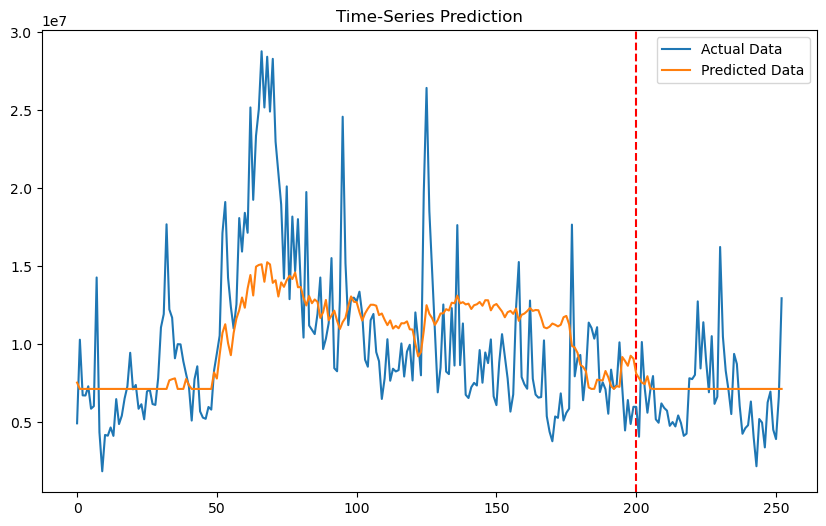

In [13]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy() 
label_y = df_y_ms.data.numpy()

predicted= ms.inverse_transform(predicted) 
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6)) 
plt.axvline(x=200, c='r', linestyle='--') 

plt.plot(label_y, label='Actual Data') 
plt.plot(predicted, label='Predicted Data') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 